# Loan Default Prediction

Due to the fact that the existing dataset is not balanced, which means that there are many more customers with clear loan status than customers who default, we used the sampling method to address this issue. The sampling method is a special case of statistical inference where observations are selected from a population to answer a question about the whole population.

# Obtaining the Data

In [162]:
# importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf



from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings('ignore')

import itertools
from collections import Counter


#from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate,cross_val_score

#resample the data
from imblearn.over_sampling import SMOTE,SMOTENC


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix,classification_report,precision_score, recall_score,accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

#Remove warnings
import warnings
warnings.filterwarnings('ignore')




%matplotlib inline
from matplotlib.pylab import rcParams
from matplotlib.ticker import FuncFormatter

from catboost import CatBoostClassifier



In [163]:
pip install plotly-express

Note: you may need to restart the kernel to use updated packages.


In [164]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [165]:
def thousands(tick_val,pos):
    """adapted from https://dfrieds.com/data-visualizations/how-format-large-tick-values.html"""
    val = round(tick_val/1000, 1)
    new_tick_format = '{:.0f}K'.format(val)
    return new_tick_format
form = FuncFormatter(thousands)

Due to imbalance dataset, the models in previous notebook have very high accuracy scores and recall scores.
In this note book, I will resample the dataset and run the models again.

In [166]:
loan=pd.read_csv('/Users/claudiatsai/Documents/Flatiron/Phase_5/data_loan_default_prediction/selected_features.csv')

In [167]:
loan.head()

,loan_amnt,term,int_rate,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,tot_cur_bal,mort_acc,num_actv_bc_tl,pub_rec_bankruptcies
0,3600.000,36 months,13.990,C4,leadman,10+ years,MORTGAGE,55000.000,Not Verified,Fully Paid,...,0.000,2765.000,29.700,13.000,w,Individual,144904.000,1.000,2.000,0.000
1,24700.000,36 months,11.990,C1,Engineer,10+ years,MORTGAGE,65000.000,Not Verified,Fully Paid,...,0.000,21470.000,19.200,38.000,w,Individual,204396.000,4.000,5.000,0.000
2,20000.000,60 months,10.780,B4,truck driver,10+ years,MORTGAGE,63000.000,Not Verified,Fully Paid,...,0.000,7869.000,56.200,18.000,w,Joint App,189699.000,5.000,2.000,0.000
3,35000.000,60 months,14.850,C5,Information Systems Officer,10+ years,MORTGAGE,110000.000,Source Verified,Current,...,0.000,7802.000,11.600,17.000,w,Individual,301500.000,1.000,4.000,0.000
4,10400.000,60 months,22.450,F1,Contract Specialist,3 years,MORTGAGE,104433.000,Source Verified,Fully Paid,...,0.000,21929.000,64.500,35.000,w,Individual,331730.000,6.000,4.000,0.000


# Scrubbing and Cleaning Data

In [168]:
loan.dtypes

loan_amnt               float64
term                     object
int_rate                float64
sub_grade                object
emp_title                object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
loan_status              object
purpose                  object
addr_state               object
fico_range_low          float64
fico_range_high         float64
open_acc                float64
pub_rec                 float64
revol_bal               float64
revol_util              float64
total_acc               float64
initial_list_status      object
application_type         object
tot_cur_bal             float64
mort_acc                float64
num_actv_bc_tl          float64
pub_rec_bankruptcies    float64
dtype: object

### loan_status 

Loan_status is the dependent variable in the dataset.

In [169]:
loan.loan_status.value_counts(normalize=True)

Fully Paid                                            0.476
Current                                               0.389
Charged Off                                           0.119
Late (31-120 days)                                    0.009
In Grace Period                                       0.004
Late (16-30 days)                                     0.002
Does not meet the credit policy. Status:Fully Paid    0.001
Does not meet the credit policy. Status:Charged Off   0.000
Default                                               0.000
Name: loan_status, dtype: float64

Focus on "Fully Paid" and "Charged Off" in loan_status.

In [170]:
#loan = loan[(loan['loan_status'] == 'Fully Paid') | (loan['loan_status'] == 'Charged Off')]

In [171]:
loan_list=['Charged Off', 'Fully Paid']
loan= loan.loc[loan['loan_status'].isin(loan_list)]

In [172]:
loan.loan_status.value_counts()

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

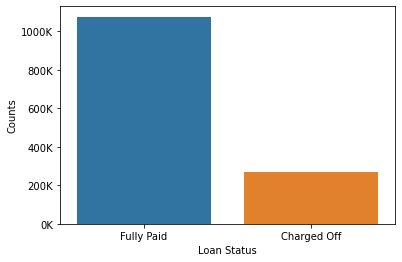

In [173]:
loan_status = loan['loan_status'].value_counts()
ax = sns.barplot(x = loan_status.index, y = loan_status.values)
ax.set_ylabel('Counts')
ax.set_xlabel('Loan Status')
ax.yaxis.set_major_formatter(form)

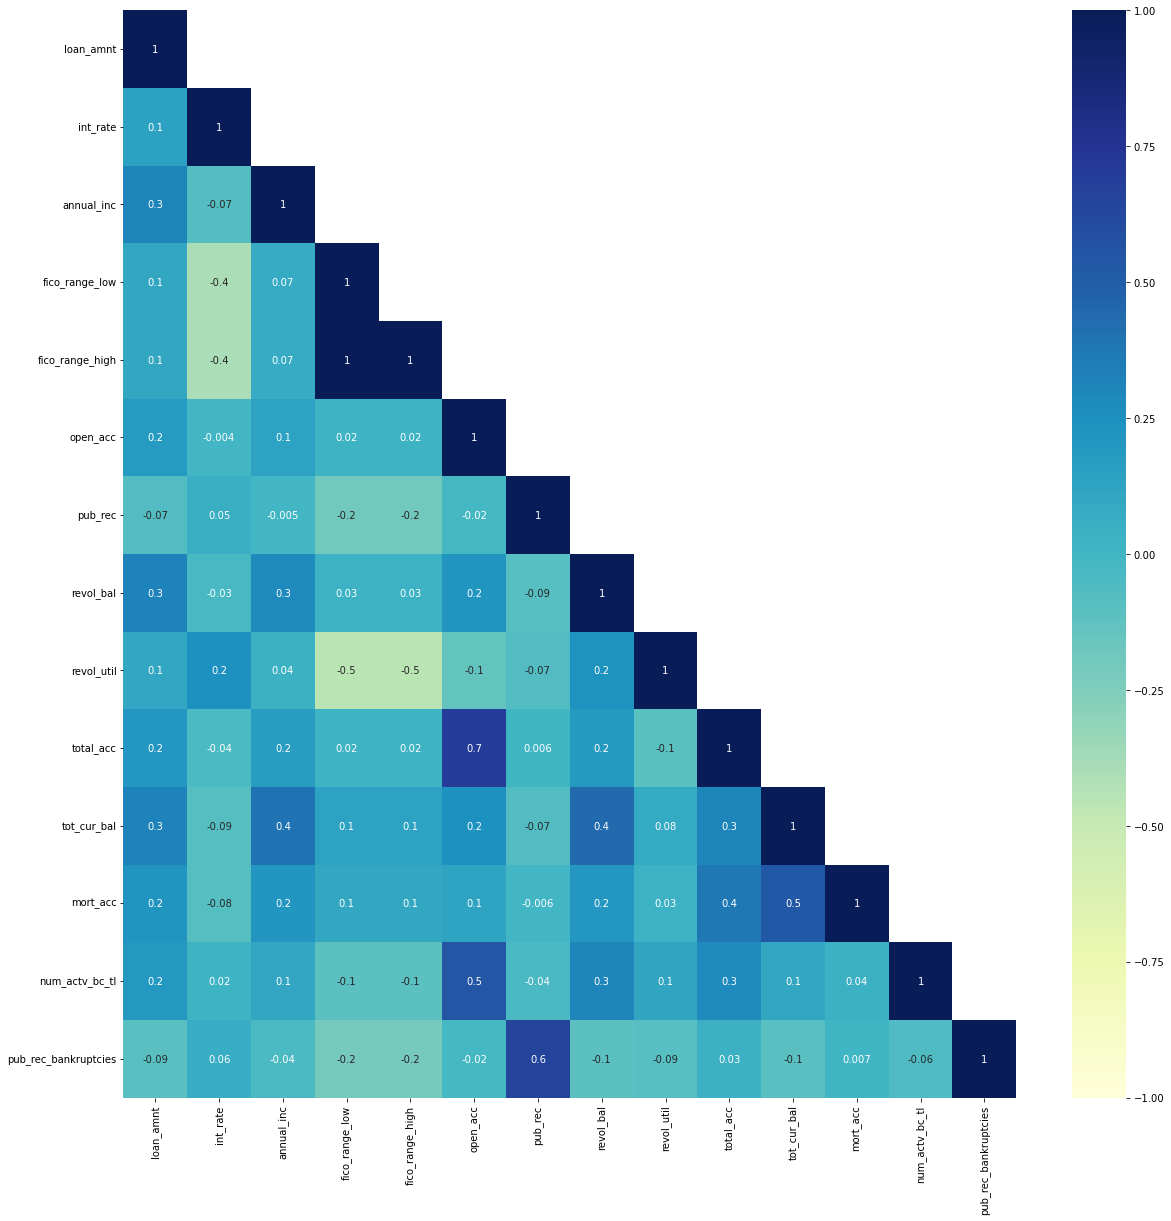

In [174]:
'''showed the lower triangular heatmap
https://datavizpyr.com/how-to-make-lower-triangular-heatmap-with-python/
'''
corr = loan.corr()
corr_tri = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(data = corr_tri, center = 0, cmap = "YlGnBu", annot = True, fmt='.1g',vmin=-1);

Check the null values in each variable

In [175]:
loan.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
sub_grade                   0
emp_title               85785
emp_length              78511
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
purpose                     0
addr_state                  0
fico_range_low              0
fico_range_high             0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                857
total_acc                   0
initial_list_status         0
application_type            0
tot_cur_bal             67527
mort_acc                47281
num_actv_bc_tl          67527
pub_rec_bankruptcies      697
dtype: int64

In [176]:
null_data = ((loan.isna().sum()/len(loan))*100)[((loan.isna().sum()/len(loan))*100) > 0]
null_data

emp_title              6.377
emp_length             5.836
revol_util             0.064
tot_cur_bal            5.019
mort_acc               3.515
num_actv_bc_tl         5.019
pub_rec_bankruptcies   0.052
dtype: float64

### emp_title

In [177]:
loan.emp_title.describe()

count     1259525
unique     378353
top       Teacher
freq        21268
Name: emp_title, dtype: object

The unique values of emp_titles are 378353 which is way more too large to put into categories. 
Drop this column.

In [178]:
loan = loan.drop('emp_title', axis=1)

### emp_length

In [179]:
loan.emp_length.value_counts(normalize=True)

10+ years   0.349
2 years     0.096
< 1 year    0.085
3 years     0.085
1 year      0.070
5 years     0.066
4 years     0.064
6 years     0.050
8 years     0.048
7 years     0.047
9 years     0.040
Name: emp_length, dtype: float64

In [180]:
emp_length_order = [ '< 1 year', '1 year', '2 years', '3 years', '4 years',
                    '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']

<AxesSubplot:xlabel='emp_length', ylabel='count'>

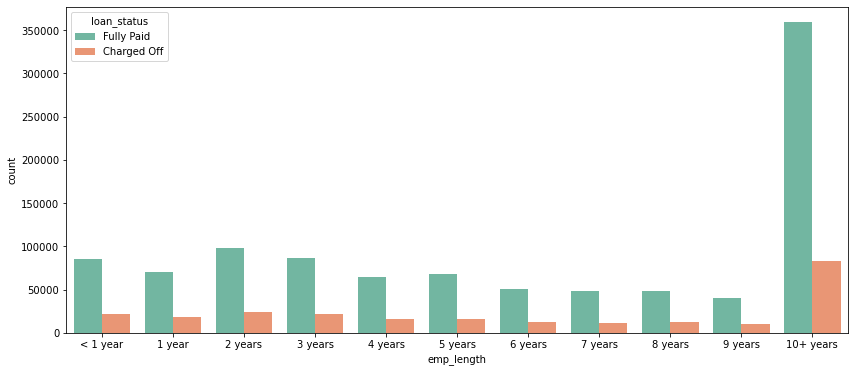

In [181]:
plt.figure(figsize=(14,6))
sns.countplot(x='emp_length',data=loan,order=emp_length_order,hue='loan_status', palette='Set2')

In [182]:
for order in emp_length_order:
    print(f"{order}:")
    print(f"{loan[loan.emp_length == order].loan_status.value_counts(normalize=True)}")
    

< 1 year:
Fully Paid    0.795
Charged Off   0.205
Name: loan_status, dtype: float64
1 year:
Fully Paid    0.794
Charged Off   0.206
Name: loan_status, dtype: float64
2 years:
Fully Paid    0.802
Charged Off   0.198
Name: loan_status, dtype: float64
3 years:
Fully Paid    0.800
Charged Off   0.200
Name: loan_status, dtype: float64
4 years:
Fully Paid    0.803
Charged Off   0.197
Name: loan_status, dtype: float64
5 years:
Fully Paid    0.804
Charged Off   0.196
Name: loan_status, dtype: float64
6 years:
Fully Paid    0.806
Charged Off   0.194
Name: loan_status, dtype: float64
7 years:
Fully Paid    0.805
Charged Off   0.195
Name: loan_status, dtype: float64
8 years:
Fully Paid    0.801
Charged Off   0.199
Name: loan_status, dtype: float64
9 years:
Fully Paid    0.801
Charged Off   0.199
Name: loan_status, dtype: float64
10+ years:
Fully Paid    0.812
Charged Off   0.188
Name: loan_status, dtype: float64


From above data, charged off rate is 19%-20% in each employee lengths. So emp_length will be dropped as well.

In [183]:
loan = loan.drop('emp_length',axis=1)

### revol_util

revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

Feature "revol_util" has 0.06% null values in the dataset. Use the mean value to fill the null value.

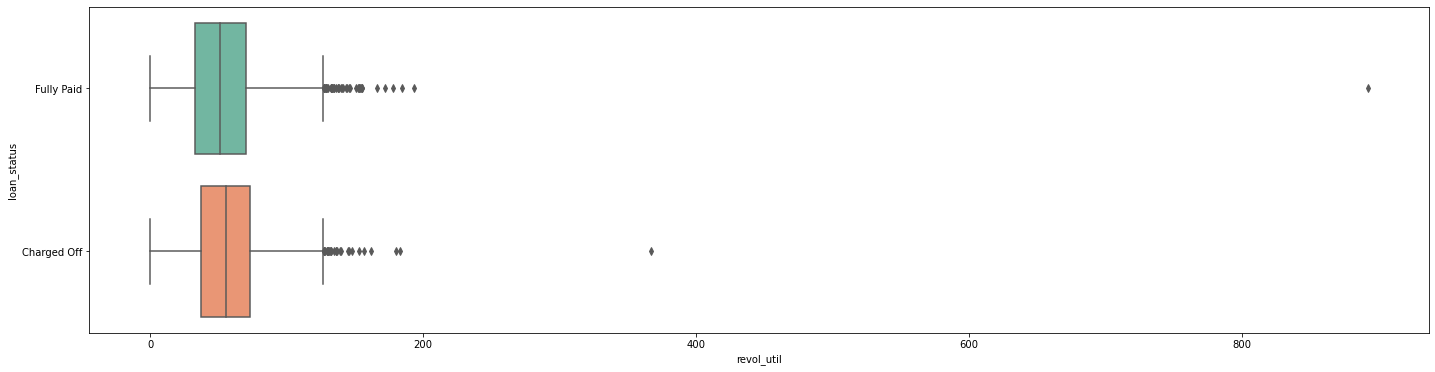

In [184]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='revol_util', y='loan_status', palette='Set2');

In [185]:
loan.revol_util = loan.revol_util.fillna(loan.revol_util.mean())

In [186]:
loan.revol_util.isna().sum()

0

In [187]:
loan.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.000,54.756,23.858,0.000,37.400,55.500,73.100,366.600
Fully Paid,1076751.000,51.075,24.619,0.000,32.500,51.300,70.000,892.300


In [188]:
loan.shape

(1345310, 23)

From above boxplot, outliers are observed.

In [189]:
loan = loan[loan['revol_util'] < 150]

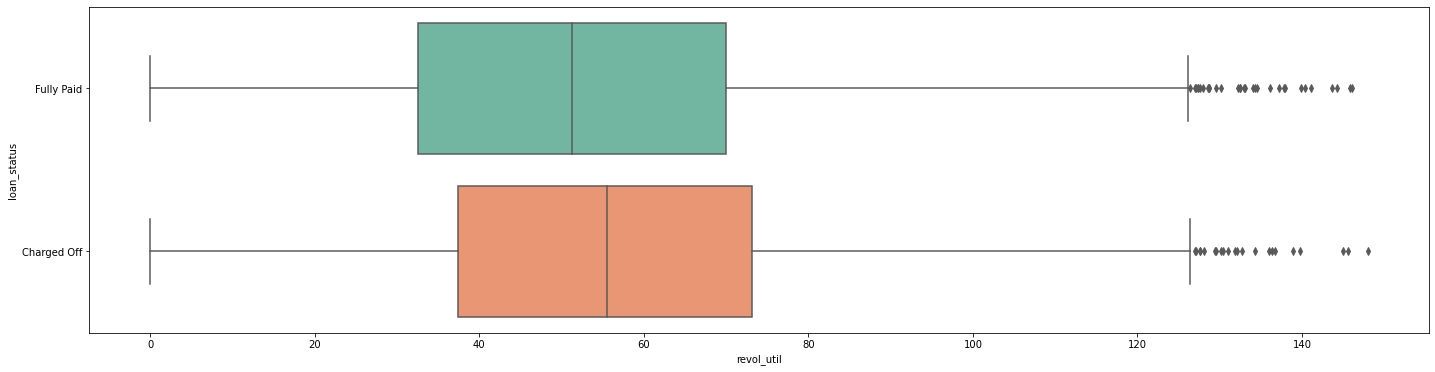

In [190]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='revol_util', y='loan_status', palette='Set2');

### revol_bal 

In [191]:
loan.groupby('loan_status')['revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268553.000,15353.432,18954.234,0.000,5990.000,11072.000,19101.000,1746716.000
Fully Paid,1076737.000,16471.013,23086.415,0.000,5931.000,11150.000,19925.000,2904836.000


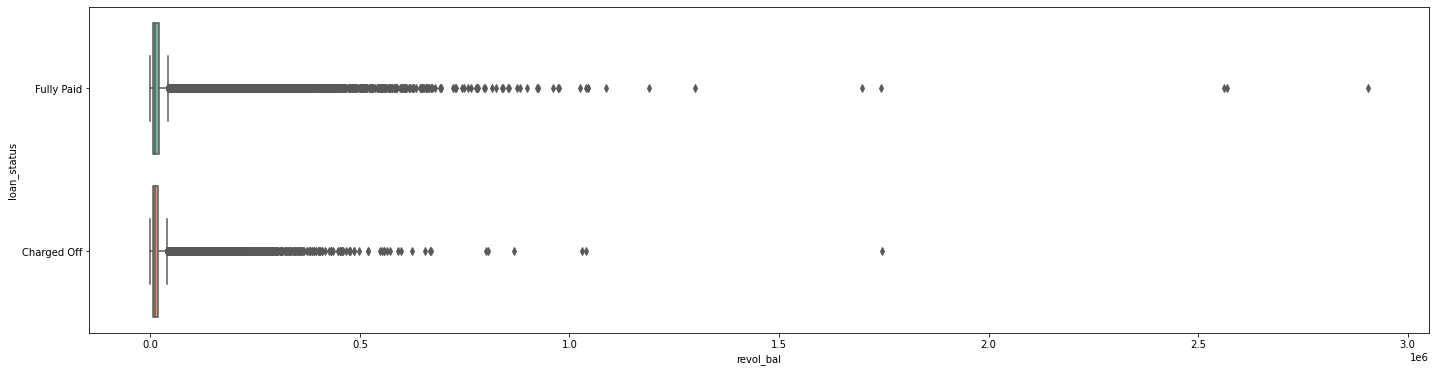

In [192]:

plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='revol_bal', y='loan_status', palette='Set2');


From above boxplot, outliers are observed. Keep the revolving balance less than $100,000.

In [193]:
loan = loan[loan['revol_bal'] < 100000]

In [194]:
loan.groupby('loan_status')['revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,266943.000,14427.093,12618.010,0.000,5962.000,11001.000,18890.500,99991.000
Fully Paid,1066241.000,14919.490,13529.348,0.000,5887.000,11028.000,19544.000,99992.000


### mort_acc

#Feature "mort_acc" has 3.51% null values in the dataset. 

In [195]:
loan.mort_acc.isna().sum()

47037

In [196]:
loan.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,260082.000,1.360,1.815,0.000,0.000,1.000,2.000,29.000
Fully Paid,1026065.000,1.728,2.021,0.000,0.000,1.000,3.000,51.000


It looks like there are some outliers in the "mort_acc".

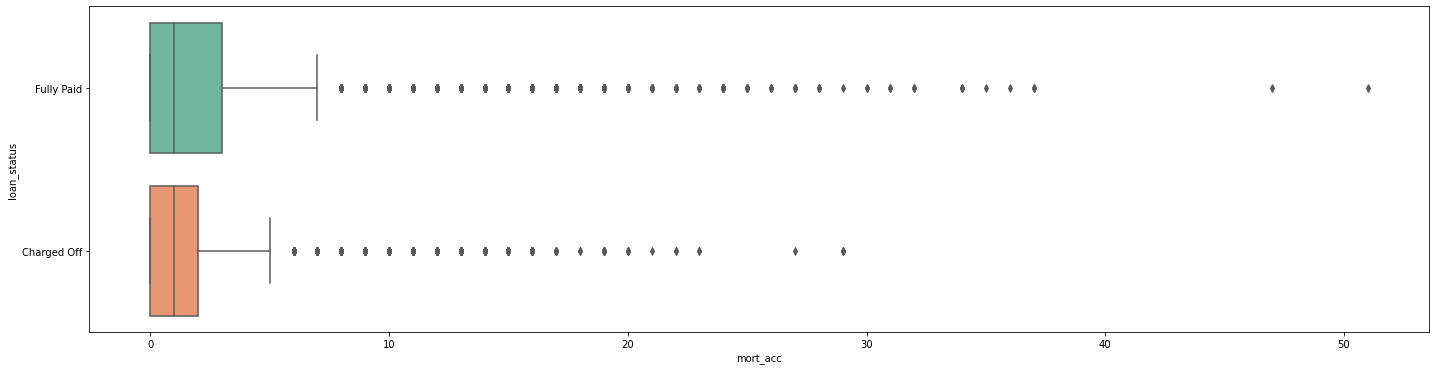

In [197]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='mort_acc', y='loan_status', palette='Set2');

In [198]:
loan = loan[loan['mort_acc'] < 10]

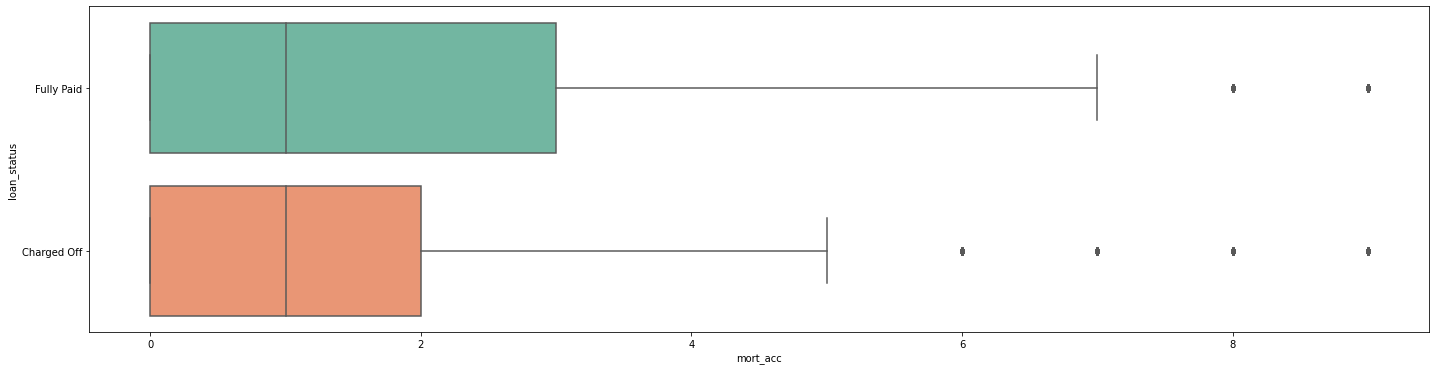

In [199]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='mort_acc', y='loan_status', palette='Set2');

In [200]:
loan.mort_acc.value_counts()

0.000    523154
1.000    224572
2.000    186529
3.000    137029
4.000     93239
5.000     56405
6.000     31791
7.000     16394
8.000      8097
9.000      4131
Name: mort_acc, dtype: int64

In [201]:
loan.mort_acc.isna().sum()

0

In [202]:
loan.shape

(1281341, 23)

### num_actv_bc_tl

#Feature "num_actv_ba_tl" has 5.01% null values in the dataset.

In [203]:
loan.groupby('loan_status')['num_actv_bc_tl'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,256082.000,3.816,2.352,0.000,2.000,3.000,5.000,30.000
Fully Paid,1005182.000,3.578,2.194,0.000,2.000,3.000,5.000,33.000


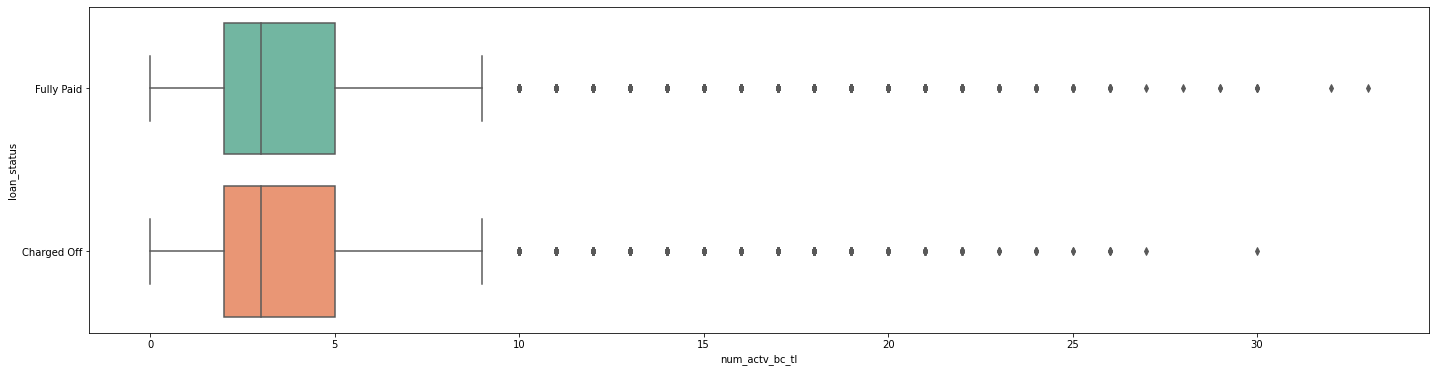

In [204]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='num_actv_bc_tl', y='loan_status', palette='Set2');

In [205]:
loan.num_actv_bc_tl.value_counts()

3.000     271162
2.000     258563
4.000     209855
1.000     145277
5.000     139720
6.000      86523
7.000      50711
8.000      29670
0.000      27100
9.000      17418
10.000     10210
11.000      6043
12.000      3565
13.000      2120
14.000      1194
15.000       793
16.000       452
17.000       337
18.000       191
19.000       133
20.000        69
21.000        45
22.000        35
23.000        21
24.000        21
25.000        13
26.000        11
30.000         5
27.000         2
29.000         2
32.000         1
33.000         1
28.000         1
Name: num_actv_bc_tl, dtype: int64

In [206]:
loan = loan[loan['num_actv_bc_tl'] < 10]

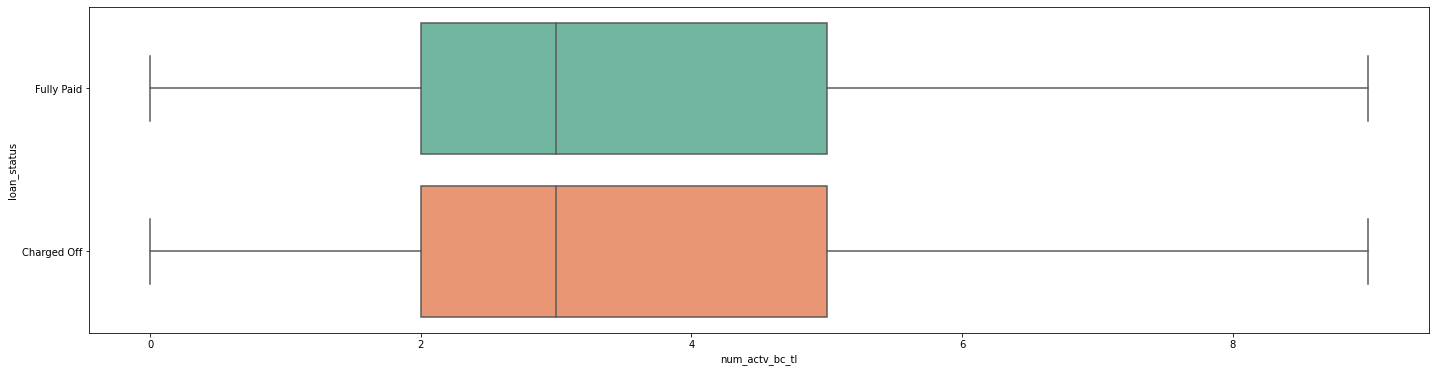

In [207]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='num_actv_bc_tl', y='loan_status', palette='Set2');

In [208]:
loan.corr()['num_actv_bc_tl'].sort_values()[:-1]

fico_range_high        -0.115
fico_range_low         -0.115
pub_rec_bankruptcies   -0.053
pub_rec                -0.030
int_rate                0.023
mort_acc                0.028
tot_cur_bal             0.081
annual_inc              0.087
revol_util              0.123
loan_amnt               0.185
total_acc               0.237
revol_bal               0.407
open_acc                0.473
Name: num_actv_bc_tl, dtype: float64

In [209]:
loan.shape

(1235999, 23)

### pub_rec_bankruptcies

Number of public record bankruptcies.

In [210]:
loan.pub_rec_bankruptcies.isna().sum()

0

In [211]:
loan.groupby('loan_status')['pub_rec_bankruptcies'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,249420.000,0.160,0.412,0.000,0.000,0.000,0.000,11.000
Fully Paid,986579.000,0.138,0.381,0.000,0.000,0.000,0.000,12.000


In [212]:
loan.pub_rec_bankruptcies.value_counts()

0.000     1072993
1.000      153183
2.000        7661
3.000        1560
4.000         393
5.000         137
6.000          44
7.000          14
8.000           9
9.000           3
11.000          1
12.000          1
Name: pub_rec_bankruptcies, dtype: int64

In [213]:
loan['pub_rec_bankruptcies']= loan['pub_rec_bankruptcies'].apply(lambda x:0 if x==0 else 1 )
                                                                  
loan['pub_rec_bankruptcies'].value_counts()

0    1072993
1     163006
Name: pub_rec_bankruptcies, dtype: int64

### pub_rec

Number of derogatory public records.

In [214]:
loan.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,249420.000,0.257,0.671,0.000,0.000,0.000,0.000,86.000
Fully Paid,986579.000,0.219,0.599,0.000,0.000,0.000,0.000,63.000


In [215]:
loan.pub_rec.value_counts()

0.000     1015437
1.000      184481
2.000       23788
3.000        7191
4.000        2555
5.000        1232
6.000         613
7.000         270
8.000         156
9.000          79
10.000         56
11.000         40
12.000         27
13.000         17
15.000          9
21.000          6
19.000          5
16.000          5
18.000          5
14.000          4
17.000          3
24.000          2
22.000          2
20.000          2
28.000          2
86.000          1
63.000          1
25.000          1
54.000          1
34.000          1
37.000          1
40.000          1
46.000          1
47.000          1
49.000          1
23.000          1
61.000          1
Name: pub_rec, dtype: int64

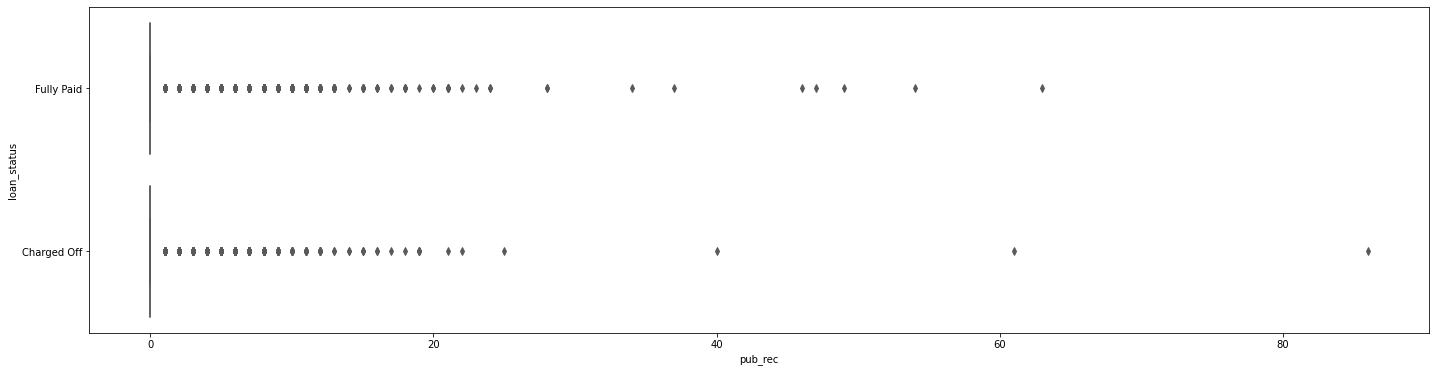

In [216]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='pub_rec', y='loan_status', palette='Set2');

In [217]:
loan['pub_rec']= loan['pub_rec'].apply(lambda x:0 if x==0 else 1 )
                                                  
loan['pub_rec'].value_counts()

0    1015437
1     220562
Name: pub_rec, dtype: int64

### loan_amnt

In [218]:
loan.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,249420.000,15493.915,8744.101,1000.000,9000.000,14075.000,20000.000,40000.000
Fully Paid,986579.000,14069.840,8594.166,1000.000,7500.000,12000.000,20000.000,40000.000


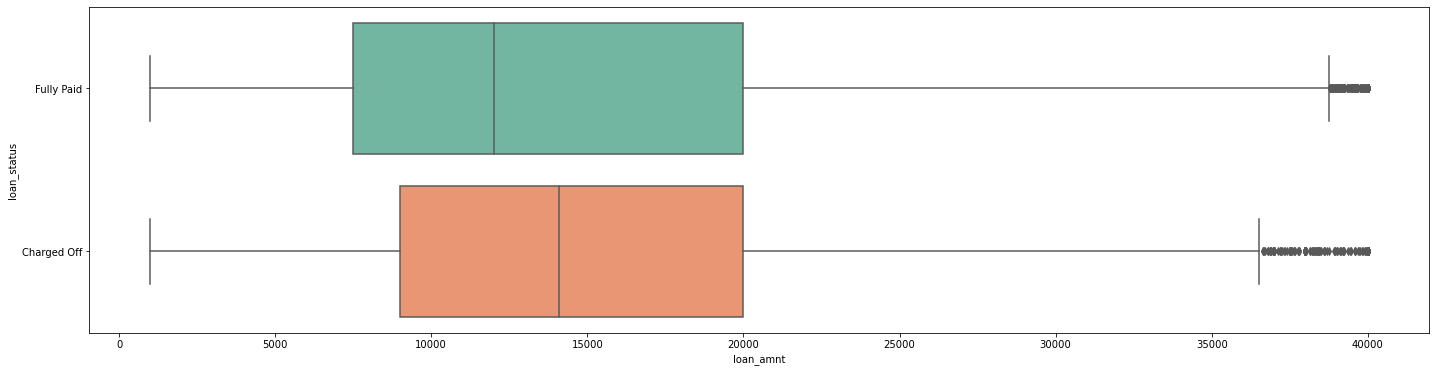

In [219]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='loan_amnt', y='loan_status', palette='Set2');

In [220]:
loan_amt_state = pd.DataFrame(loan.groupby('addr_state')['loan_amnt'].mean().sort_values()).reset_index()

In [221]:
import plotly.express as px
fig = px.choropleth(loan_amt_state,
                    locations='addr_state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='loan_amnt',
                    color_continuous_scale="Viridis_r", 
                    
                    
                    )
fig.show()

### term

<AxesSubplot:xlabel='term', ylabel='count'>

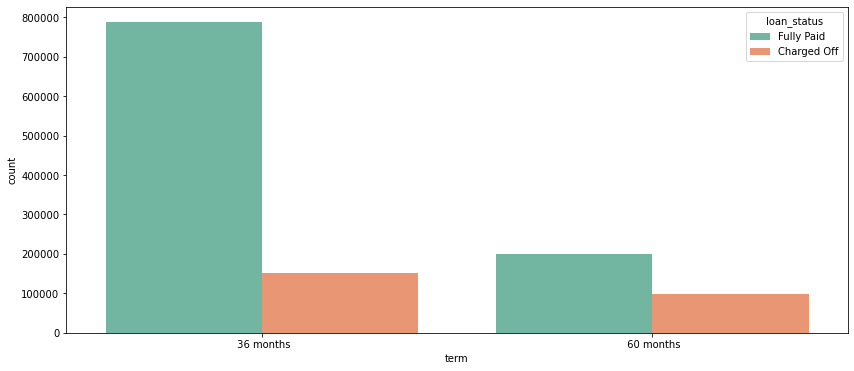

In [222]:
plt.figure(figsize=(14,6))
sns.countplot(x='term',data=loan,hue='loan_status', palette='Set2')

In [223]:
loan_term= pd.DataFrame(loan.groupby('term')['loan_status'].count()).reset_index()
loan_term
                

,term,loan_status
0,36 months,939145
1,60 months,296854


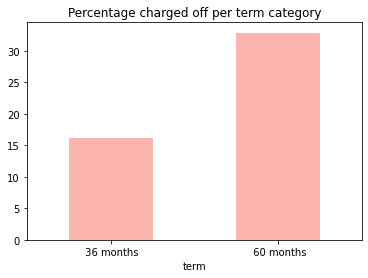

In [224]:
charged_off = loan[loan['loan_status']=="Charged Off"].groupby("term").count()['loan_status']
fully_paid = loan[loan['loan_status']=="Fully Paid"].groupby("term").count()['loan_status']
percent_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percent_charged_off.plot(kind='bar', cmap='Pastel1')
plt.title("Percentage charged off per term category")
plt.xticks(rotation=0);

Loan term with 60 month has higher rate of charged off.

In [225]:
dummies_term = pd.get_dummies(loan['term'], prefix='term',drop_first=True)
loan= pd.concat([loan.drop('term', axis=1), dummies_term], axis=1)

### int_rate

In [226]:
loan.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,249420.000,15.767,4.925,5.310,12.350,15.050,18.550,30.990
Fully Paid,986579.000,12.655,4.547,5.310,9.170,12.290,15.310,30.990


<AxesSubplot:xlabel='int_rate', ylabel='loan_amnt'>

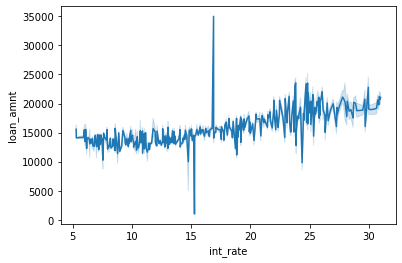

In [227]:
plt.figure(figsize=(24,6))
sns.lineplot(data=loan, x="int_rate", y="loan_amnt")

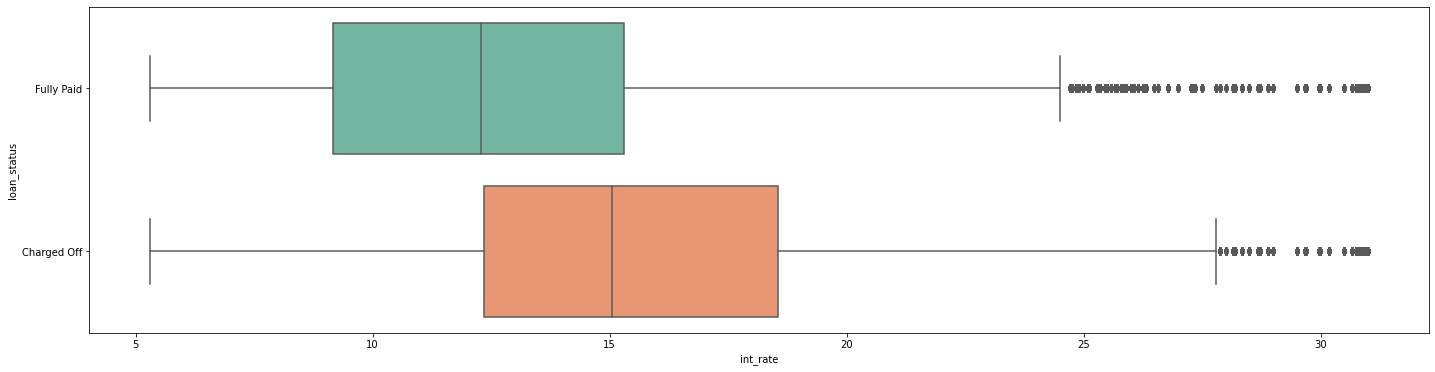

In [228]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='int_rate', y='loan_status', palette='Set2');

In [229]:
'''
plt.plot(x, y, label = "line 1")
plt.plot(y, x, label = "line 2")
plt.plot(x, np.sin(x), label = "curve 1")
plt.plot(x, np.cos(x), label = "curve 2")
plt.legend()
plt.show()
'''

'\nplt.plot(x, y, label = "line 1")\nplt.plot(y, x, label = "line 2")\nplt.plot(x, np.sin(x), label = "curve 1")\nplt.plot(x, np.cos(x), label = "curve 2")\nplt.legend()\nplt.show()\n'

### sub_grade 

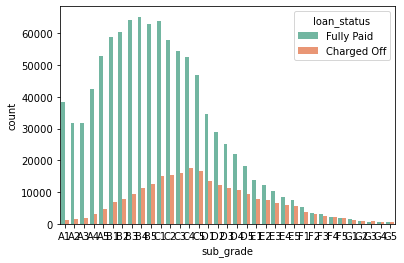

In [230]:
subgrade_order = sorted(loan['sub_grade'].unique().tolist())
sns.countplot(x='sub_grade',data=loan,order = subgrade_order, palette='Set2',hue='loan_status');


In [231]:
dummies_subgrade = pd.get_dummies(loan['sub_grade'], prefix='sub_grade',drop_first=True)
loan= pd.concat([loan.drop('sub_grade', axis=1), dummies_subgrade], axis=1)

### home_ownership

In [232]:
loan['home_ownership'].value_counts()

MORTGAGE    608692
RENT        492585
OWN         134353
ANY            280
NONE            45
OTHER           44
Name: home_ownership, dtype: int64

In [233]:
owndership_list=['MORTGAGE', 'RENT','OTHER','OWN']
loan= loan.loc[loan['home_ownership'].isin(owndership_list)]

In [234]:
loan.home_ownership.value_counts()

MORTGAGE    608692
RENT        492585
OWN         134353
OTHER           44
Name: home_ownership, dtype: int64

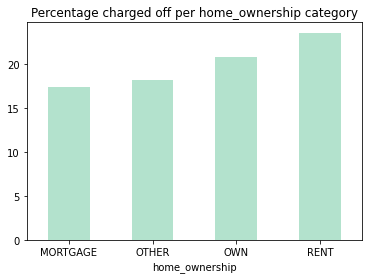

In [235]:
charged_off = loan[loan['loan_status']=="Charged Off"].groupby("home_ownership").count()['loan_status']
fully_paid = loan[loan['loan_status']=="Fully Paid"].groupby("home_ownership").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='Pastel2')
plt.title("Percentage charged off per home_ownership category")
plt.xticks(rotation=0);

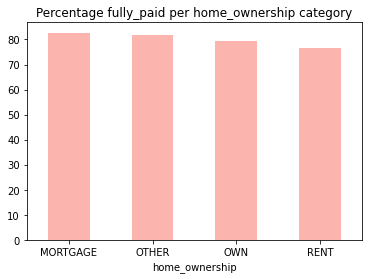

In [236]:
charged_off = loan[loan['loan_status']=="Charged Off"].groupby("home_ownership").count()['loan_status']
fully_paid = loan[loan['loan_status']=="Fully Paid"].groupby("home_ownership").count()['loan_status']
percentage_fully_paid = (fully_paid * 100)/(charged_off + fully_paid)
percentage_fully_paid.plot(kind='bar', cmap='Pastel1')
plt.title("Percentage fully_paid per home_ownership category")
plt.xticks(rotation=0);

In [237]:
#dummies_subgrade = pd.get_dummies(loan['sub_grade'], prefix='term',drop_first=True)
#loan= pd.concat([loan.drop('sub_grade', axis=1), dummies_subgrade], axis=1)

In [238]:
dummies_ownership = pd.get_dummies(loan['home_ownership'], prefix='home_ownership',drop_first=True)
loan= pd.concat([loan.drop('home_ownership', axis=1), dummies_ownership], axis=1)

### annual_inc

In [239]:
loan.groupby('loan_status')['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,249360.000,69467.381,65356.198,0.000,43000.000,60000.000,84000.000,9500000.000
Fully Paid,986314.000,76264.558,67181.191,0.000,46900.000,65000.000,91000.000,10999200.000


In [240]:
loan_state = pd.DataFrame(loan.groupby('addr_state')['annual_inc'].mean().sort_values()).reset_index()

In [241]:
import plotly.express as px
fig = px.choropleth(loan_state,
                    locations='addr_state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='annual_inc',
                    color_continuous_scale="Viridis_r", 
                    
                    
                    )
fig.show()

In [242]:
loan.shape

(1235674, 58)

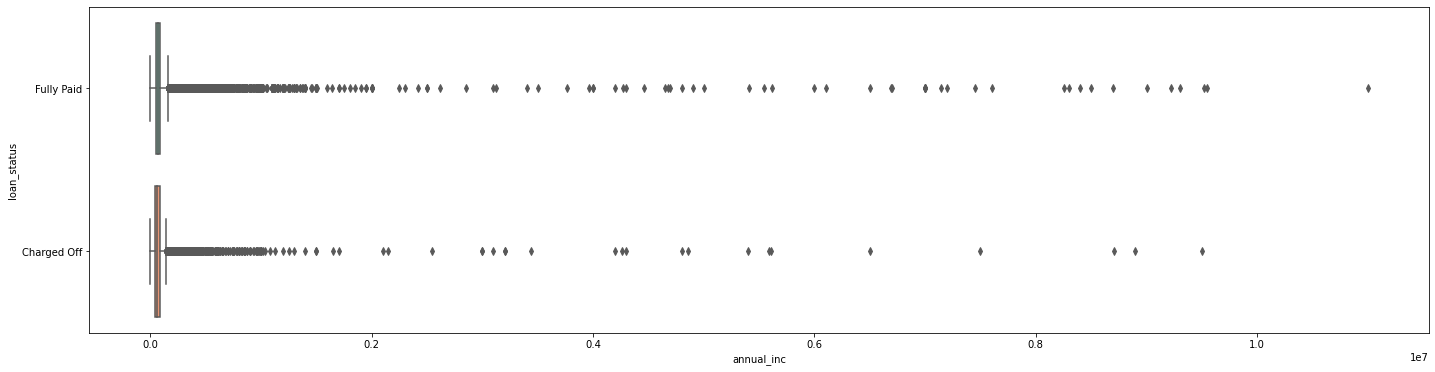

In [243]:
plt.figure(figsize=(24,6))
sns.boxplot(data=loan, x='annual_inc', y='loan_status', palette='Set2');

From above, outliers are observed. 

In [244]:
print(len(loan[loan['annual_inc']>250000])/loan.shape[0])

0.008131594579152754


Less than 1% customers have annual income greater than 250k.
Keep annual income less than 250k.

In [245]:
loan = loan[loan['annual_inc'] <= 250000]

### verification_status

In [246]:
loan.verification_status.value_counts()

Source Verified    482194
Verified           374769
Not Verified       368663
Name: verification_status, dtype: int64

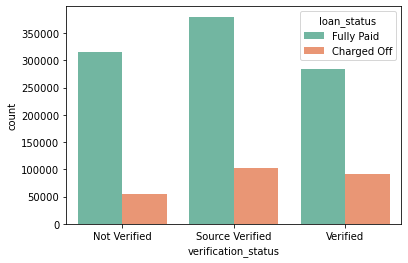

In [247]:
sns.countplot(data=loan, x='verification_status', hue='loan_status', palette='Set2');

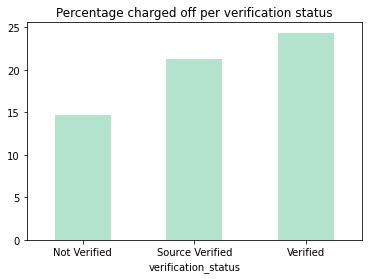

In [248]:
charged_off = loan[loan['loan_status']=="Charged Off"].groupby("verification_status").count()['loan_status']
fully_paid = loan[loan['loan_status']=="Fully Paid"].groupby("verification_status").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='Pastel2')
plt.title("Percentage charged off per verification status")
plt.xticks(rotation=0);

In [249]:
dummies_verification_status = pd.get_dummies(loan['verification_status'], drop_first=True)
loan= pd.concat([loan.drop('verification_status', axis=1), dummies_verification_status], axis=1)

### initial_list_status

In [250]:
loan.initial_list_status.value_counts()

w    750443
f    475183
Name: initial_list_status, dtype: int64

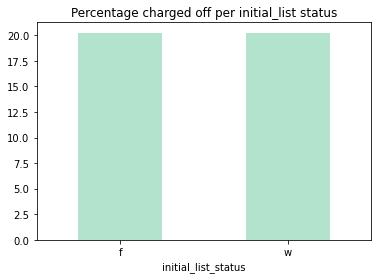

In [251]:
charged_off = loan[loan['loan_status']=="Charged Off"].groupby("initial_list_status").count()['loan_status']
fully_paid = loan[loan['loan_status']=="Fully Paid"].groupby("initial_list_status").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='Pastel2')
plt.title("Percentage charged off per initial_list status")
plt.xticks(rotation=0);

The percentage charged off in initial_list_status has no large difference. Drop this column.

In [252]:
loan=loan.drop('initial_list_status',axis=1)

### purpose

In [253]:
loan.purpose.value_counts()

debt_consolidation    718127
credit_card           271256
home_improvement       78179
other                  69809
major_purchase         25522
medical                14055
car                    12091
small_business         11923
moving                  8464
vacation                8244
house                   6325
wedding                  860
renewable_energy         770
educational                1
Name: purpose, dtype: int64

In [254]:
purpose_df= loan.purpose.value_counts()

In [255]:
purpose_df.head()

debt_consolidation    718127
credit_card           271256
home_improvement       78179
other                  69809
major_purchase         25522
Name: purpose, dtype: int64

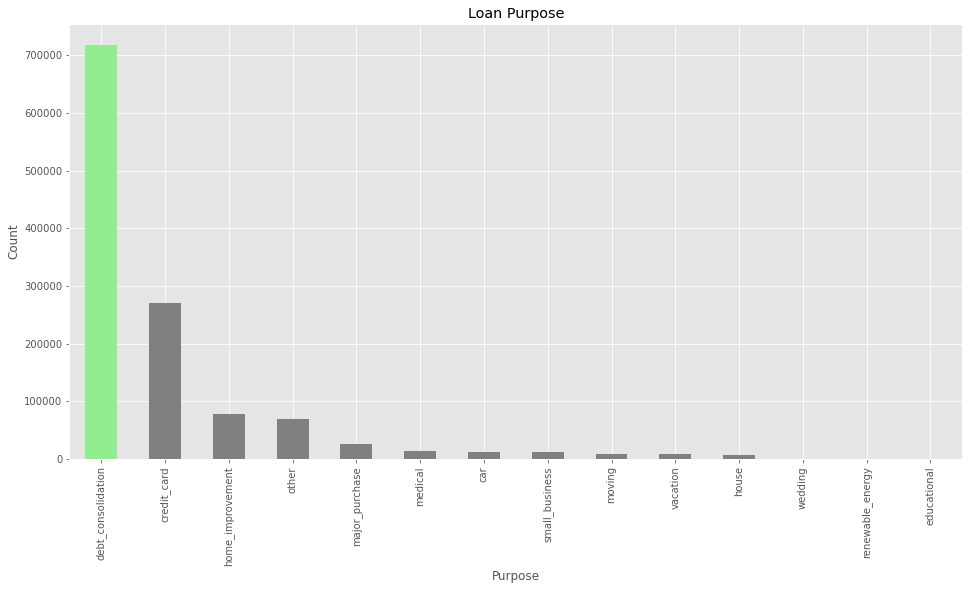

In [258]:
fig,ax=plt.subplots(figsize=(16,8))
plt.style.use('ggplot')
clrs=['grey' if (value < max(purpose_df.values)) else 'lightgreen' for value in purpose_df.values]
purpose_df.plot(kind='bar',color=clrs)
ax.set_ylabel('Count')
ax.set_xlabel('Purpose')
ax.set_title('Loan Purpose')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

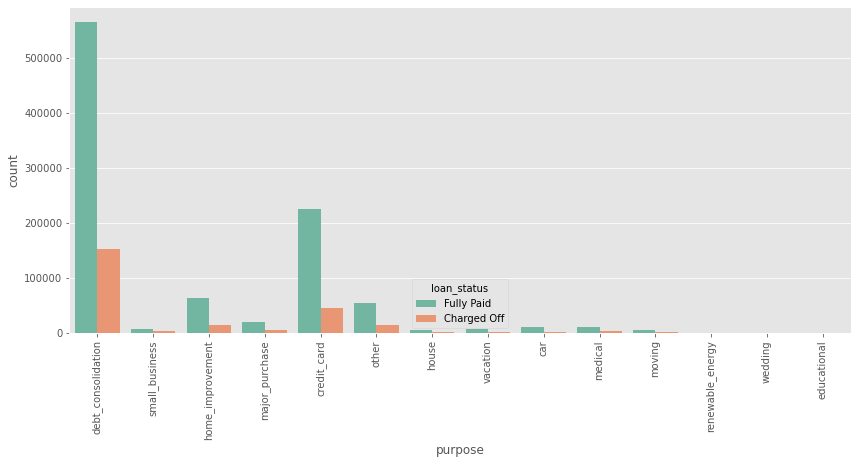

In [259]:
plt.figure(figsize=(14,6))
purpose_order = sorted(loan['purpose'].unique().tolist())
sns.countplot(x='purpose',data=loan,hue='loan_status', palette='Set2')
plt.xticks(rotation=90);

In [260]:
dummies_purpose = pd.get_dummies(loan['purpose'], prefix='purpose',drop_first=True)
loan= pd.concat([loan.drop('purpose', axis=1), dummies_purpose], axis=1)

### addr_state 

In [261]:
loan.addr_state.value_counts()

CA    175798
TX    101375
NY     97960
FL     86886
IL     46720
NJ     42617
PA     41346
OH     40604
GA     39484
NC     34871
VA     34158
MI     32813
AZ     29954
MD     28137
MA     27428
CO     27252
WA     26725
MN     22168
IN     21124
TN     19741
MO     19530
NV     18737
CT     17326
WI     16432
AL     15462
OR     15181
SC     14758
LA     14267
KY     11915
OK     11459
KS     10435
AR      9278
UT      9235
NM      6842
MS      6383
HI      6235
NH      5889
RI      5313
WV      4476
MT      3559
NE      3489
DE      3443
DC      2986
AK      2933
WY      2705
SD      2571
VT      2469
ME      1955
ID      1641
ND      1559
IA         2
Name: addr_state, dtype: int64

In [262]:
dummies_state = pd.get_dummies(loan['addr_state'], drop_first=True)
loan= pd.concat([loan.drop('addr_state', axis=1), dummies_state], axis=1)

### application type

In [263]:
loan.application_type.value_counts()

Individual    1200478
Joint App       25148
Name: application_type, dtype: int64

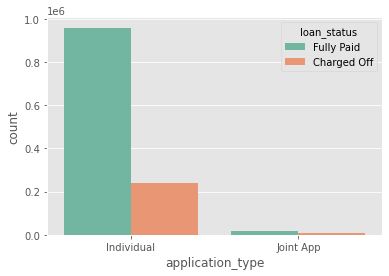

In [264]:
sns.countplot(data=loan, x='application_type', hue='loan_status', palette='Set2');

In [265]:
dummies_apptype = pd.get_dummies(loan['application_type'], drop_first=True)
loan= pd.concat([loan.drop('application_type', axis=1), dummies_apptype], axis=1)

### fico_range_low & fico_range_high 

In [266]:
loan.groupby('loan_status')['fico_range_high'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,247991.000,691.361,25.649,664.000,674.000,684.000,704.000,850.000
Fully Paid,977635.000,701.302,32.465,664.000,674.000,694.000,719.000,850.000


In [267]:
loan.groupby('loan_status')['fico_range_low'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,247991.000,687.361,25.649,660.000,670.000,680.000,700.000,845.000
Fully Paid,977635.000,697.302,32.464,660.000,670.000,690.000,715.000,845.000


There is no significant difference between fico_range_high and fico_range_low.

Keep fico_range_high in the dataset

In [268]:
loan = loan.drop('fico_range_low',axis=1)

### Convert "Loan status" into binary feature

In [269]:
# Convert columns with yes or no to binary
label_encoder = LabelEncoder()
loan['loan_status'] = label_encoder.fit_transform(loan['loan_status'])

In [270]:
loan.head()

,loan_amnt,int_rate,annual_inc,loan_status,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,Joint App
0,3600.000,13.990,55000.000,1,679.000,7.000,0,2765.000,29.700,13.000,...,0,0,0,0,0,0,0,0,0,0
1,24700.000,11.990,65000.000,1,719.000,22.000,0,21470.000,19.200,38.000,...,0,0,0,0,0,0,0,0,0,0
2,20000.000,10.780,63000.000,1,699.000,6.000,0,7869.000,56.200,18.000,...,0,0,0,0,0,0,0,0,0,1
4,10400.000,22.450,104433.000,1,699.000,12.000,0,21929.000,64.500,35.000,...,0,0,0,0,0,0,0,0,0,0
5,11950.000,13.440,34000.000,1,694.000,5.000,0,8822.000,68.400,6.000,...,0,0,0,0,0,0,0,0,0,0


## Resample the Dataset

Current class for loan status

In [271]:
loan.loan_status.value_counts()

1    977635
0    247991
Name: loan_status, dtype: int64

Text(0.5, 0, 'Loan Status')

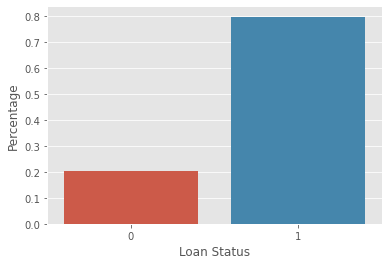

In [272]:
loan_status = loan['loan_status'].value_counts(normalize=True)
ax = sns.barplot(x = loan_status.index, y = loan_status.values)
ax.set_ylabel('Percentage')
ax.set_xlabel('Loan Status')

From above bar chart, imbalanced class was observed. Due to the large dataset, under-sampling the majority class.

In [273]:
# Class count
count_class_1, count_class_0 = loan.loan_status.value_counts()

# Divide by class
df_class_0 = loan[loan['loan_status'] == 0]
df_class_1 = loan[loan['loan_status'] == 1]

In this case, paid-off is the majority class in loan status . After under-sampling paid-off class, concatenating the under-sampling paid-off class and Charged class.

In [274]:
df_class_1_under = df_class_1.sample(count_class_0)
loan_under = pd.concat([df_class_1_under, df_class_0], axis=0)

Plot the loan_status again to show the balanced class.

Random under-sampling:
1    247991
0    247991
Name: loan_status, dtype: int64


Text(0.5, 0, 'Loan Status')

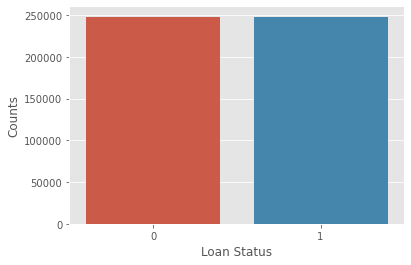

In [275]:
loan_status_plot= loan_under['loan_status'].value_counts()
ax = sns.barplot(x = loan_status_plot.index, y = loan_status_plot.values)
print('Random under-sampling:')
print(loan_under.loan_status.value_counts())
ax.set_ylabel('Counts')
ax.set_xlabel('Loan Status')

## Define X and Y

In [276]:
X = loan_under.drop(['loan_status'],axis=1)
y = loan_under['loan_status']

## Train Test Split 

Split the data into train and test set by test size 25%

In [277]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state = 123)

## Standardize the Data

Standardize the data since the features in the data set have different ranges.

In [278]:
#Instantiate StandardScaler
scaler = StandardScaler()

#Transform X_train to scaled data set and fit the model with scaled X train data
scaled_X_train = scaler.fit_transform(X_train)

#Transform X_test to scaled data set
scaled_X_test= scaler.transform(X_test)

#Convert scaled data into a DataFrame
scaled_X_train = pd.DataFrame(scaled_X_train,columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaled_X_test,columns=X_test.columns)

## Logistic Regression Model

test:
              precision    recall  f1-score   support

           0       0.64      0.68      0.66     61788
           1       0.66      0.62      0.64     62208

    accuracy                           0.65    123996
   macro avg       0.65      0.65      0.65    123996
weighted avg       0.65      0.65      0.65    123996

train:
              precision    recall  f1-score   support

           0       0.65      0.68      0.66    186203
           1       0.66      0.63      0.64    185783

    accuracy                           0.65    371986
   macro avg       0.65      0.65      0.65    371986
weighted avg       0.65      0.65      0.65    371986

Test Recall_score 0.6223476080246914
Test accuracy score 0.6522387818961902


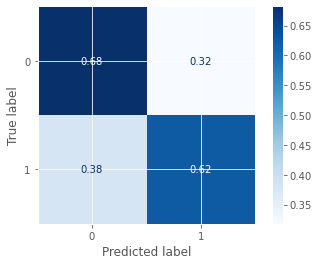

In [299]:
lr= LogisticRegression(random_state = 123)
lr.fit(scaled_X_train,y_train)

y_train_pred = lr.predict(scaled_X_train)
y_test_pred = lr.predict(scaled_X_test)


plot_confusion_matrix(lr,scaled_X_test,y_test,
                                normalize='true',
                                cmap='Blues')


rs = recall_score(y_train,y_train_pred)
print(f"test:\n{classification_report(y_test,y_test_pred)}")
print(f"train:\n{classification_report(y_train,y_train_pred)}")

#print Test recall score
rs = recall_score(y_test,y_test_pred)
print(f"Test Recall_score {rs}")

# Print the accuracy on test set

print(f"Test accuracy score {lr.score(scaled_X_test,y_test)}")

Create a function to print scores and confusion matrix for the models

In [280]:
def eval_model(model,X_train,y_train,X_test,y_test):
    
    #fit the model
    model.fit(X_train,y_train)
    
    #predict the target variable
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #plot the confusion matrix with test set
    plot_confusion_matrix(model,X_test,y_test,normalize='true',cmap='Blues')
    
    #print recall score and classification report for train set and test set
    rs_train = recall_score(y_train,y_train_pred)
    rs_test = recall_score(y_test, y_test_pred)
    print(f"test:\n{classification_report(y_test,y_test_pred)}")
    print(f"train:\n{classification_report(y_train,y_train_pred)}")
    print(f"Train Recall_score {rs_train}")
    print(f"Test Recall_score {rs_test}")

    # Print the accuracy of a model
    acc_score = model.score(X_test,y_test)
    acc_score_train = model.score(X_train,y_train)
    print(f"Train accuracy score {acc_score_train}")
    print(f"Test accuracy score {acc_score}")

## Decision Tree Model (Baseline Model)

In [281]:
# Instantiate a DecisionTreeClassifier()
dt= DecisionTreeClassifier(max_depth=3,random_state=123)

test:
              precision    recall  f1-score   support

           0       0.61      0.74      0.67     61788
           1       0.67      0.52      0.59     62208

    accuracy                           0.63    123996
   macro avg       0.64      0.63      0.63    123996
weighted avg       0.64      0.63      0.63    123996

train:
              precision    recall  f1-score   support

           0       0.61      0.74      0.67    186203
           1       0.67      0.52      0.59    185783

    accuracy                           0.63    371986
   macro avg       0.64      0.63      0.63    371986
weighted avg       0.64      0.63      0.63    371986

Train Recall_score 0.5244559512980197
Test Recall_score 0.5200778034979424
Train accuracy score 0.6334620120112048
Test accuracy score 0.6307622826542791


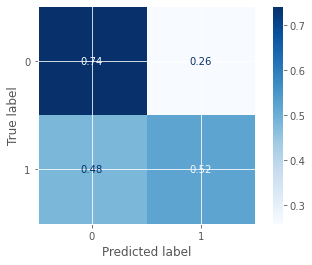

In [282]:
eval_model(dt,scaled_X_train,y_train,scaled_X_test,y_test)

## Random Forest Model

In [283]:
rf = RandomForestClassifier(random_state =123)

test:
              precision    recall  f1-score   support

           0       0.64      0.68      0.66     61788
           1       0.66      0.62      0.64     62208

    accuracy                           0.65    123996
   macro avg       0.65      0.65      0.65    123996
weighted avg       0.65      0.65      0.65    123996

train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186203
           1       1.00      1.00      1.00    185783

    accuracy                           1.00    371986
   macro avg       1.00      1.00      1.00    371986
weighted avg       1.00      1.00      1.00    371986

Train Recall_score 1.0
Test Recall_score 0.6190039866255144
Train accuracy score 1.0
Test accuracy score 0.651843607858318


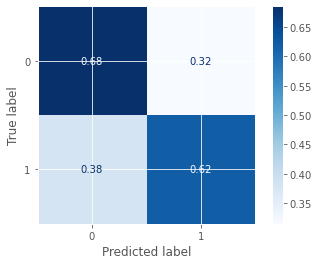

In [284]:
eval_model(rf,scaled_X_train,y_train,scaled_X_test,y_test)

## XG Boost Model

In [285]:
xg = XGBClassifier(random_state =123)

[23:01:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
test:
              precision    recall  f1-score   support

           0       0.65      0.68      0.67     61788
           1       0.67      0.64      0.65     62208

    accuracy                           0.66    123996
   macro avg       0.66      0.66      0.66    123996
weighted avg       0.66      0.66      0.66    123996

train:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69    186203
           1       0.69      0.66      0.68    185783

    accuracy                           0.68    371986
   macro avg       0.68      0.68      0.68    371986
weighted avg       0.68      0.68      0.68    371986

Train Recall_score 0.6609754390875376
Test Recall_score 0.6355613425925926
Train 

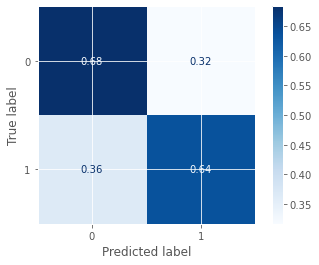

In [286]:
eval_model(xg,scaled_X_train,y_train,scaled_X_test,y_test)

In [287]:
cb = CatBoostClassifier(
    iterations=10, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)

0:	learn: 0.6810490	total: 81.2ms	remaining: 731ms
1:	learn: 0.6713938	total: 96ms	remaining: 384ms
2:	learn: 0.6633248	total: 112ms	remaining: 262ms
3:	learn: 0.6569153	total: 127ms	remaining: 191ms
4:	learn: 0.6520906	total: 143ms	remaining: 143ms
5:	learn: 0.6477597	total: 158ms	remaining: 105ms
6:	learn: 0.6441654	total: 174ms	remaining: 74.4ms
7:	learn: 0.6411637	total: 189ms	remaining: 47.1ms
8:	learn: 0.6385594	total: 205ms	remaining: 22.8ms
9:	learn: 0.6365217	total: 220ms	remaining: 0us
test:
              precision    recall  f1-score   support

           0       0.63      0.68      0.66     61788
           1       0.66      0.60      0.63     62208

    accuracy                           0.64    123996
   macro avg       0.64      0.64      0.64    123996
weighted avg       0.64      0.64      0.64    123996

train:
              precision    recall  f1-score   support

           0       0.64      0.69      0.66    186203
           1       0.66      0.61      0.63    185

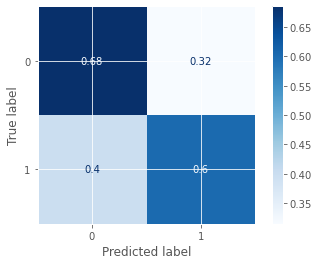

In [288]:
eval_model(cb,scaled_X_train,y_train,scaled_X_test,y_test)

## Tuning XG Boost Model

In [289]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [1,2,5,10],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [290]:
grid_clf = GridSearchCV(xg,param_grid,cv=5,scoring='recall',n_jobs=1)
grid_clf.fit(scaled_X_train,y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(scaled_X_train)
test_preds = grid_clf.predict(scaled_X_test)
training_accuracy = accuracy_score(y_train,training_preds)
test_accuracy = accuracy_score(y_test,test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

[23:02:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:02:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:02:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:02:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[23:07:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:07:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:07:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:07:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[23:23:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[23:38:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:39:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:39:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[23:47:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [295]:
xg_grid=XGBClassifier(learning_rate=0.2,max_depth=5, min_child_weight=2,n_estimators=100, subsample=0.7)

[00:13:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
test:
              precision    recall  f1-score   support

           0       0.65      0.68      0.67     61788
           1       0.67      0.64      0.65     62208

    accuracy                           0.66    123996
   macro avg       0.66      0.66      0.66    123996
weighted avg       0.66      0.66      0.66    123996

train:
              precision    recall  f1-score   support

           0       0.66      0.69      0.68    186203
           1       0.68      0.65      0.66    185783

    accuracy                           0.67    371986
   macro avg       0.67      0.67      0.67    371986
weighted avg       0.67      0.67      0.67    371986

Train Recall_score 0.6489937184780092
Test Recall_score 0.638695987654321
Train a

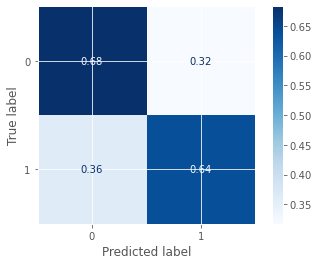

In [296]:
eval_model(xg_grid,scaled_X_train,y_train,scaled_X_test,y_test)

## Find Feature Importances in XGBoost Model

Calculating feature importances and plot the feature by sorted values

In [297]:
# Calculate feature importances
feature_importances = xg_grid.feature_importances_

# Create a list of features: done
feature_list = list(scaled_X_train.columns)

# Save the results inside a DataFrame using feature_list as an index
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])

# Sort values to learn most important features
relative_importances.sort_values(by="importance", ascending=False)

# Show top 10 features
result = relative_importances.reset_index().sort_values('importance',ascending=False).iloc[:10]

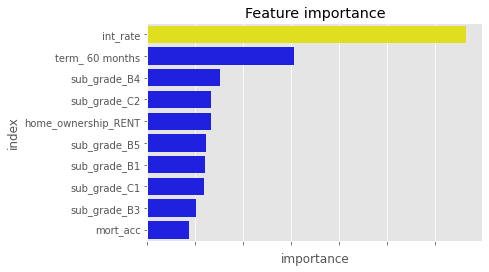

In [298]:
# plot feature imporances with sorted values
clrs=['blue' if (value < max(result.importance)) else 'yellow' for value in result.importance]
ax=sns.barplot(data=result,x='importance',y='index',palette=clrs,ci= None)
ax.set_xlabel('importance')
ax.set_ylabel('index')
ax.set_title('Feature importance')

ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

# Conclusion

Interest rate, pay term, subgrade, home ownership and mortgage accounts are the feature importances in the dataset

# Furthermore